# Material science example

In this example, we will demonstrate the LVGP methodology on the lacunar spinels dataset from [Wang et al. (2020)](https://doi.org/10.1063/5.0018811).  The dataset consists of high-fidelity density functional theory calculations for bandgaps and stabilities of 270 material compounds belonging to the lacunar spinel family $AM^aM_3^bQ_8$. 

- The $A$ atom has three levels $\{$Al, In, Ga$\}$, the $M^a$ atom has six levels $\{$V, Nb, Ta, Cr, Mo, W$\}$, the $M^b$ atom has five levels $\{$V, Nb, Ta, Mo, W$\}$, and the $Q$ atom has 3 levels $\{$S, Se, Te$\}$. 
- There are no quantitative inputs!

The dataset is in the file `spinels.csv`.

**Note**: This example requires [`pandas`](https://pandas.pydata.org) to be installed.

In [1]:
import torch
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lvgp_pytorch.models import LVGPR
from lvgp_pytorch.optim import noise_tune
from lvgp_pytorch.utils.variables import CategoricalVariable
from lvgp_pytorch.utils.input_space import InputSpace

from typing import Dict
from copy import deepcopy

%matplotlib inline
plt.rcParams['figure.dpi']=150
plt.rcParams['font.family']='serif'

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

In [2]:
dat = pd.read_csv('spinels.csv')
dat

,A,Ma,Mb,Q,stability,band_gap
0,Al,Cr,Mo,S,-0.107245,0.000
1,Al,Cr,Mo,Se,0.055310,0.000
2,Al,Cr,Mo,Te,0.733715,0.000
3,Al,Cr,Nb,S,0.393349,0.000
4,Al,Cr,Nb,Se,1.073608,0.000
...,...,...,...,...,...,...
265,In,W,V,Se,0.553423,0.422
266,In,W,V,Te,0.473401,0.000
267,In,W,W,S,-1.871288,0.462
268,In,W,W,Se,-1.589787,0.397


We create the `InputSpace` utility object to transform the data into the required format for modeling - a categorical input variable with L levels needs to be encoded as integers 0,...,L-1. 

In [3]:
config = InputSpace()
col_names = ['A','Ma','Mb','Q']
elems = [
    CategoricalVariable(name=name,levels=dat[name].unique()) \
    for name in col_names
]
config.add_inputs(elems)
config

Input space with variables:

A, Type: Categorical, Levels: {Al, Ga, In}
Ma, Type: Categorical, Levels: {Cr, Mo, Nb, Ta, V, W}
Mb, Type: Categorical, Levels: {Mo, Nb, Ta, V, W}
Q, Type: Categorical, Levels: {S, Se, Te}

In [4]:
# convert dataframe to requisite format for modeling
all_x = torch.from_numpy(np.row_stack([
    # iterate over rows and convert each row into a 
    # numpy array with encoded entries. Stack all these
    # arrays using row_stack from numpy and then convert
    # the resulting object into a tensor using 
    # torch.from_numpy
    config.get_array_from_dict(row) for _,row in dat[config.get_variable_names()].iterrows() 
])).double()
print('Inputs in required tensor form:')
print(all_x)

bandgap = torch.from_numpy(dat['band_gap'].values)
stability = torch.from_numpy(dat['stability'].values)

Inputs in required tensor form:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 2.],
        ...,
        [2., 5., 4., 0.],
        [2., 5., 4., 1.],
        [2., 5., 4., 2.]], dtype=torch.float64)


For testing, we randomly divide the data into training and test sets with a 60-40 split. There are 162 training observations for the model.

In [5]:
# generate 100 samples
set_seed(1)
num_train_samples = int(all_x.shape[0]*0.6)
idxs_train = np.random.choice(all_x.shape[0],num_train_samples,replace=False)
idxs_test = np.array([idx for idx in np.arange(all_x.shape[0]) if idx not in idxs_train])


train_x,test_x = all_x[idxs_train,:],all_x[idxs_test,:]
# first response - stability
train_y1,test_y1 = stability[idxs_train],stability[idxs_test]
# second response - bandgap
train_y2,test_y2 = bandgap[idxs_train],bandgap[idxs_test]

## Model for stability

In [6]:
# create LVGP instance
set_seed(14)
model_stability = LVGPR(
    train_x=train_x,
    train_y=train_y1,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
).double()

# optimize model using noise tuning strategy
start_time = time.time()
_ = noise_tune(model_stability, num_restarts = 9)
fit_time_stability = time.time()-start_time
print('Training time: %6.2f s'%fit_time_stability)

# prediction on test set
with torch.no_grad():
    test_mean,test_std = model_stability.predict(test_x,return_std=True)
    
# print RRMSE
rrmse_stability = torch.sqrt(((test_y1-test_mean)**2).mean()/((test_y1-test_y1.mean())**2).mean())
print('Train RRMSE for stability: %5.3f'%rrmse_stability.item())

Training time:  53.90 s
Train RRMSE for stability: 0.336


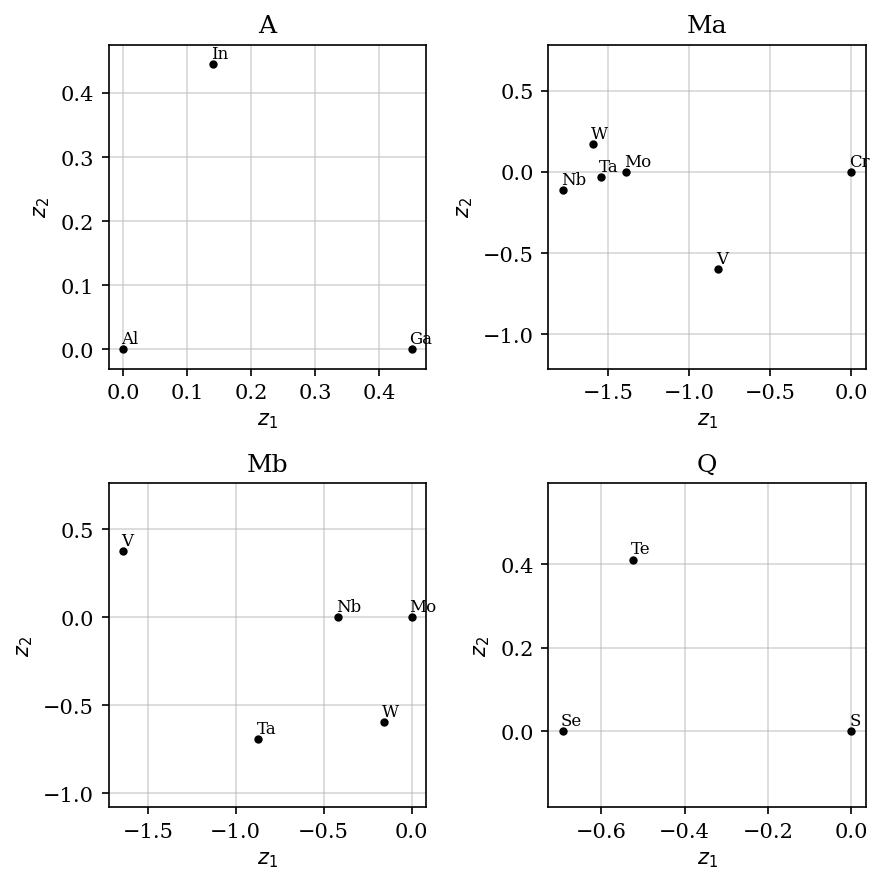

In [7]:
fig,axs = plt.subplots(2,2,figsize=(6,6))
for i in range(2):
    for j in range(2):
        var_idx = 2*i+j
        latents = model_stability.lv_mapping_layers[var_idx].latents.detach().numpy()
        _ = axs[i,j].plot(latents[:,0],latents[:,1],'k.')

        hyp = config.get_variable_by_idx(config.qual_index[var_idx])
        # annotate the labels
        for k,level in enumerate(hyp.levels):
            _ = axs[i,j].annotate(
                str(level),latents[k,:],
                textcoords = 'offset points',
                xytext = (-1,3),
                size='8'
            )


        _ = axs[i,j].set_xlabel(r'$z_1$')
        _ = axs[i,j].set_ylabel(r'$z_2$')
        _ = axs[i,j].set_title(r'%s' %hyp.name)
        _ = axs[i,j].grid(alpha=0.5)
        _ = axs[i,j].set_aspect('equal', 'datalim')

fig.tight_layout()

## Model for bandgap

In [8]:
# create LVGP instance
set_seed(14)
model_bandgap = LVGPR(
    train_x=train_x,
    train_y=train_y2,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
).double()

# optimize model using noise tuning strategy
start_time = time.time()
_ = noise_tune(model_bandgap, num_restarts = 9)
fit_time_bandgap = time.time()-start_time
print('Training time: %6.2f s'%fit_time_bandgap)

# prediction on test set
with torch.no_grad():
    test_mean,test_std = model_bandgap.predict(test_x,return_std=True)
    
# print RRMSE
rrmse_bandgap = torch.sqrt(((test_y2-test_mean)**2).mean()/((test_y2-test_y2.mean())**2).mean())
print('Test RRMSE for bandgap: %5.3f'%rrmse_bandgap.item())

Training time:  49.24 s
Test RRMSE for bandgap: 0.471


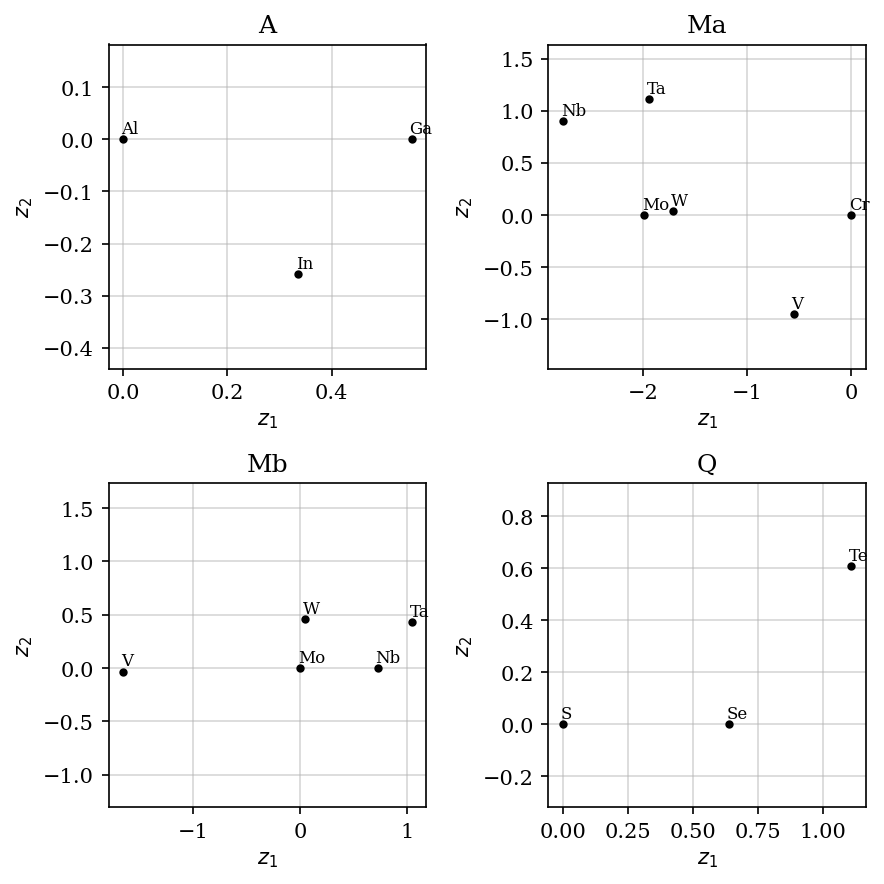

In [9]:
fig,axs = plt.subplots(2,2,figsize=(6,6))
for i in range(2):
    for j in range(2):
        var_idx = 2*i+j
        latents = model_bandgap.lv_mapping_layers[var_idx].latents.detach().numpy()
        _ = axs[i,j].plot(latents[:,0],latents[:,1],'k.')

        hyp = config.get_variable_by_idx(config.qual_index[var_idx])
        # annotate the labels
        for k,level in enumerate(hyp.levels):
            _ = axs[i,j].annotate(
                str(level),latents[k,:],
                textcoords = 'offset points',
                xytext = (-1,3),
                size='8'
            )


        _ = axs[i,j].set_xlabel(r'$z_1$')
        _ = axs[i,j].set_ylabel(r'$z_2$')
        _ = axs[i,j].set_title(r'%s' %hyp.name)
        _ = axs[i,j].grid(alpha=0.5)
        _ = axs[i,j].set_aspect('equal', 'datalim')

fig.tight_layout()

Comparing the two latent variable plots, there are two sets of patterns:

1. A and Mb seem to have similar effects on the different responses, i.e. the relation among the different levels for both these variables are similar for both responses. Note that the latent variables is **not reflection invariant**. The relative distance between two levels is all that matters for determining the similarity of the effects of those two levels on the response.
2. Ma and Q seem to have different effects on different responses.